In [1]:
import eland as ed
import numpy as np
import os

from elasticsearch import Elasticsearch
from dotenv import load_dotenv
from notebooks.backtesting_utils import get_sma

os.chdir("..")
load_dotenv()

True

In [2]:
es_url = os.environ.get('ELASTICSEARCH_URL')
es_api_key = os.environ.get('ELASTICSEARCH_API_KEY')
es = Elasticsearch(hosts=[f"{es_url}"], api_key=es_api_key)

In [11]:
%%capture
ticker="GOOG"
df_eod = ed.DataFrame(es, es_index_pattern="quant-agents_stocks-eod_*")
df_eod = df_eod[(df_eod.key_ticker == ticker)]
df_sma = ed.eland_to_pandas(df_eod).sort_values(by='date_reference', ascending=True).tail(100).set_index('date_reference')
df_sma = get_sma(df_sma)

In [12]:
df_sma.tail()

,key_ticker,val_close,val_high,val_low,val_open,val_volume,sma_short,sma_long,position,returns,strategy
date_reference,,,,,,,,,,,
2025-10-20,GOOG,257.02,257.88,254.6000,255.23,13726831,247.752,247.4640,1,0.012647,-0.012647
2025-10-21,GOOG,251.34,255.38,244.6700,255.25,27836425,248.173,247.4140,1,-0.022347,-0.022347
2025-10-22,GOOG,252.53,257.18,250.4510,255.01,19650244,248.880,247.6490,1,0.004723,0.004723
2025-10-23,GOOG,253.73,255.86,252.7683,253.70,13241319,250.032,248.0070,1,0.004741,0.004741
2025-10-24,GOOG,260.51,262.51,256.1000,257.30,18405966,252.334,248.6735,1,0.026371,0.026371


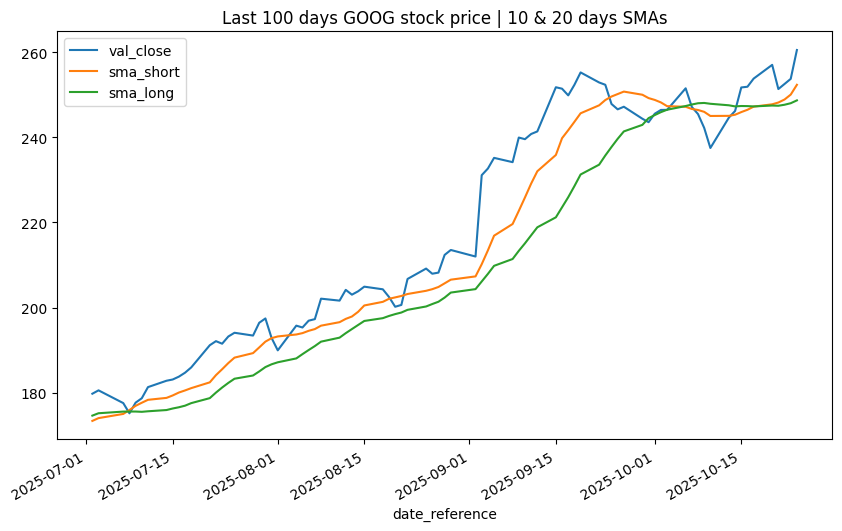

In [13]:
df_sma[["val_close", "sma_short", "sma_long"]].plot(title=f"Last 100 days {ticker} stock price | 10 & 20 days SMAs", figsize=(10, 6));

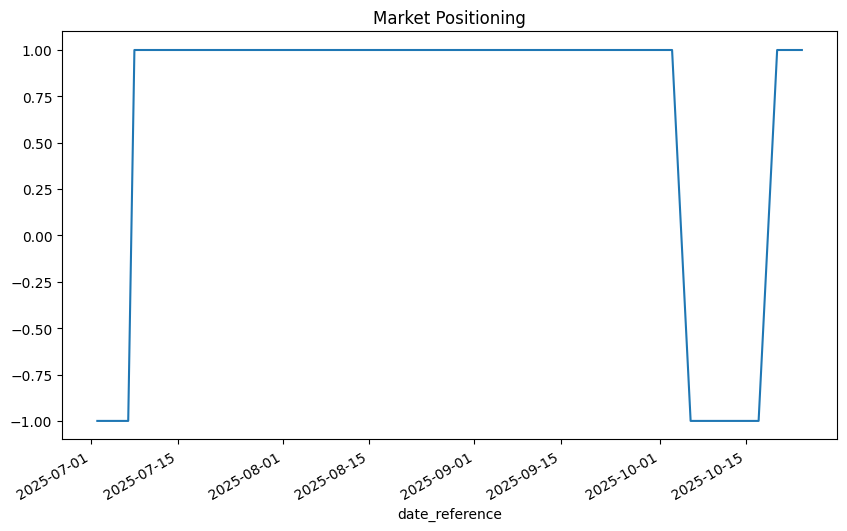

In [14]:
df_sma['position'].plot(
    ylim=[-1.1, 1.1],
    title='Market Positioning',
    figsize=(10, 6)
);

In [15]:
df_sma[['returns', 'strategy']].sum().apply(np.exp)

returns     1.472557
strategy    1.438413
dtype: float64

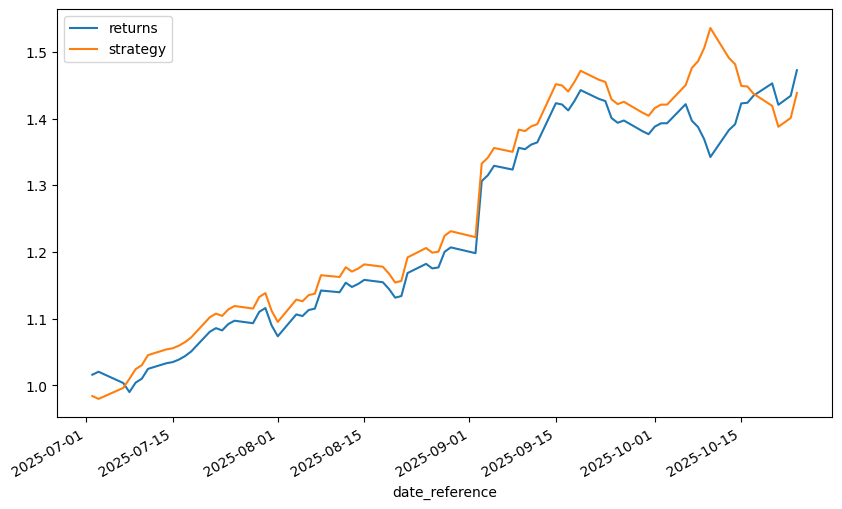

In [16]:
df_sma[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6));

In [17]:
df_sma['prev_position'] = df_sma['position'].shift(1)
crossovers = df_sma[df_sma['position'] != df_sma['prev_position']]
crossovers[['val_close', 'sma_short', 'sma_long', 'position']]

,val_close,sma_short,sma_long,position
date_reference,,,,
2025-07-02,179.76,173.371,174.6140,-1
2025-07-08,175.16,175.926,175.5715,1
2025-10-06,251.51,247.176,247.3450,-1
2025-10-20,257.02,247.752,247.4640,1
